In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
we_go_palette = {
    'purple': '#743BBC',
    'red': '#F32735',
    'navy': '#001E61',
    'blue': '#00AAE7',
    'gray': '#939598',
    'orange': '#CD5B14',
    'magenta': '#B244BC'
}

wego_colors = list(we_go_palette.values())
sns.set_palette(wego_colors)

In [3]:
wego = pd.read_csv("../data/wego_tsp_assigned.csv")

Pre-TSP – before any TSP was active (... - 02.03.2025 12:00 pm)

TSP Unconditional 1 – full TSP activation (02.03.2025 12:00 pm - 02.10.2025 12:00 pm)

TSP Schedule-Conditional – TSP activates only if bus is late more than 2 min (02.10.2025 12:00 pm - 04.28.2025 12:00 pm)

TSP Off – TSP deactivated (04.28.2025 12:00 pm - 05.05.2025 12:00 pm)

TSP Unconditional 2 – full TSP activation (05.12.2025 12:00 pm - 05.05.2025 12:00 pm)

TSP Headway-Conditional – TSP activates if headway deviation exceeds 120% (05.05.2025 12:00 pm - ...)

In [4]:
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,DWELL_IN_MINS,TIME_OF_DAY,SEASON,IS_HOLIDAY,SCHEDULED_MINUTES,IN_SCHOOL_ZONE_TIME,DAY_TYPE,DATETIME,TSP_PHASE_NAME,TSP_ACTIVE
0,120230101,3,93549161,2023-01-01,50,5000,2355,332422,0,TO DOWNTOWN,...,8.133333,Midday,Winter,False,334,N,Sunday,2023-01-01 05:34:00,Pre-TSP,N
1,120230101,3,93549162,2023-01-01,50,5000,2355,332422,0,TO DOWNTOWN,...,0.000000,Midday,Winter,False,340,N,Sunday,2023-01-01 05:40:00,Pre-TSP,N
2,120230101,3,93549163,2023-01-01,50,5000,2355,332422,0,TO DOWNTOWN,...,0.000000,Midday,Winter,False,347,N,Sunday,2023-01-01 05:47:00,Pre-TSP,N
3,120230101,3,93549164,2023-01-01,50,5000,2355,332422,0,TO DOWNTOWN,...,0.000000,Midday,Winter,False,350,N,Sunday,2023-01-01 05:50:00,Pre-TSP,N
4,120230101,3,93549165,2023-01-01,50,5000,2355,332422,0,TO DOWNTOWN,...,2.150000,Midday,Winter,False,354,N,Sunday,2023-01-01 05:54:00,Pre-TSP,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618993,120250512,1,119531049,2025-05-12,50,8401,3077,432121,0,FROM DOWNTOWN,...,4.500000,AM Peak,Spring,False,460,Y,Weekday,2025-05-12 07:40:00,TSP Unconditional 2,N
618994,120250512,1,119531638,2025-05-12,50,9302,3246,432353,0,TO DOWNTOWN,...,27.283333,PM Peak,Spring,False,905,Y,Weekday,2025-05-12 15:05:00,TSP Headway-Conditional,N
618995,120250512,1,119531639,2025-05-12,50,9302,3246,432353,0,TO DOWNTOWN,...,0.133333,PM Peak,Spring,False,918,Y,Weekday,2025-05-12 15:18:00,TSP Headway-Conditional,N
618996,120250512,1,119531770,2025-05-12,50,9950,2448,432387,0,TO DOWNTOWN,...,8.166666,PM Peak,Spring,False,920,Y,Weekday,2025-05-12 15:20:00,TSP Headway-Conditional,N


In [5]:
cln_wego = wego[(wego['OVERLOAD_ID'] == 0) &

(wego['STOP_CANCELLED'] == 0) &
(~wego['TIME_POINT_ABBR'].str.contains('HLWD', na=False)) &
(~wego['TIME_POINT_ABBR'].str.contains('WALM', na=False)) &
(wego['PREV_SCHED_STOP_CANCELLED'] == 0)]
cln_wego.dropna(subset=['ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT',
                              'SCHEDULED_HDWY', 'HDWY_DEV', 'SCHEDULED_TIME', 'ACTUAL_ARRIVAL_TIME',
                              'ACTUAL_DEPARTURE_TIME', 'SERVICE_ABBR'], inplace=True)
cln_wego.reset_index(drop=True, inplace=True)
cln_wego.info()

C:\Users\seanf\AppData\Local\Temp\ipykernel_10264\2956387535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cln_wego.dropna(subset=['ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT',


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337364 entries, 0 to 337363
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                337364 non-null  int64  
 1   SERVICE_ABBR               337364 non-null  int64  
 2   ADHERENCE_ID               337364 non-null  int64  
 3   DATE                       337364 non-null  object 
 4   ROUTE_ABBR                 337364 non-null  int64  
 5   BLOCK_ABBR                 337364 non-null  int64  
 6   OPERATOR                   337364 non-null  int64  
 7   TRIP_ID                    337364 non-null  int64  
 8   OVERLOAD_ID                337364 non-null  int64  
 9   ROUTE_DIRECTION_NAME       337364 non-null  object 
 10  TIME_POINT_ABBR            337364 non-null  object 
 11  ROUTE_STOP_SEQUENCE        337364 non-null  int64  
 12  TRIP_EDGE                  337364 non-null  int64  
 13  LATITUDE                   33

In [6]:
non_nan_values = cln_wego['SCHEDULED_HDWY'].dropna()

In [7]:
non_null_headway = cln_wego[['DATE', 'DAY_TYPE', 'TIME_OF_DAY', 'SEASON', 'IN_SCHOOL_ZONE_TIME', 'IS_HOLIDAY', 'OPERATOR', 'TIME_POINT_ABBR', 'ROUTE_DIRECTION_NAME', 'SCHEDULED_TIME', 'ACTUAL_ARRIVAL_TIME', 'ADHERENCE', 'DWELL_IN_MINS', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'DATETIME', 'TSP_PHASE_NAME',	'TSP_ACTIVE']].dropna()
non_null_headway 

,DATE,DAY_TYPE,TIME_OF_DAY,SEASON,IN_SCHOOL_ZONE_TIME,IS_HOLIDAY,OPERATOR,TIME_POINT_ABBR,ROUTE_DIRECTION_NAME,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ADHERENCE,DWELL_IN_MINS,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DATETIME,TSP_PHASE_NAME,TSP_ACTIVE
0,2023-01-01,Sunday,AM Peak,Winter,N,False,2355,WHBG,TO DOWNTOWN,07:17:00,07:20:48,-5.483333,1.683333,30.0,34.016666,4.016666,2023-01-01 07:17:00,Pre-TSP,N
1,2023-01-01,Sunday,AM Peak,Winter,N,False,2355,CH46,TO DOWNTOWN,07:20:00,07:24:18,-4.300000,0.000000,30.0,34.066666,4.066666,2023-01-01 07:20:00,Pre-TSP,N
2,2023-01-01,Sunday,AM Peak,Winter,N,False,2355,28&CHARL,TO DOWNTOWN,07:24:00,07:26:41,-2.683333,0.000000,30.0,32.516666,2.516666,2023-01-01 07:24:00,Pre-TSP,N
3,2023-01-01,Sunday,AM Peak,Winter,N,False,2355,MCC5_1,FROM DOWNTOWN,07:45:00,07:32:40,-5.516666,17.850000,30.0,36.466666,6.466666,2023-01-01 07:45:00,Pre-TSP,N
4,2023-01-01,Sunday,AM Peak,Winter,N,False,2355,28&CHARL,FROM DOWNTOWN,07:55:00,07:56:33,-1.550000,0.000000,30.0,31.233333,1.233333,2023-01-01 07:55:00,Pre-TSP,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337353,2025-05-12,Weekday,PM Peak,Spring,Y,False,754,28&CHARL,FROM DOWNTOWN,15:42:00,15:45:15,-3.250000,0.000000,15.0,17.400000,2.400000,2025-05-12 15:42:00,TSP Headway-Conditional,Y
337354,2025-05-12,Weekday,PM Peak,Spring,Y,False,754,CH46,FROM DOWNTOWN,15:47:00,15:50:35,-3.583333,0.000000,15.0,17.100000,2.100000,2025-05-12 15:47:00,TSP Headway-Conditional,Y
337355,2025-05-12,Weekday,PM Peak,Spring,Y,False,754,WHBG,FROM DOWNTOWN,15:52:00,15:56:40,-4.666666,0.000000,15.0,16.600000,1.600000,2025-05-12 15:52:00,TSP Headway-Conditional,Y
337356,2025-05-12,Weekday,PM Peak,Spring,N,False,754,WHBG,TO DOWNTOWN,16:40:00,16:42:57,-6.000000,3.050000,15.0,16.733333,1.733333,2025-05-12 16:40:00,TSP Headway-Conditional,Y


In [8]:
non_null_headway['HDWY_DEV_PCT'] = (non_null_headway['HDWY_DEV'] / non_null_headway['SCHEDULED_HDWY']) * 100
non_null_headway.sort_values(['HDWY_DEV'])

,DATE,DAY_TYPE,TIME_OF_DAY,SEASON,IN_SCHOOL_ZONE_TIME,IS_HOLIDAY,OPERATOR,TIME_POINT_ABBR,ROUTE_DIRECTION_NAME,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ADHERENCE,DWELL_IN_MINS,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DATETIME,TSP_PHASE_NAME,TSP_ACTIVE,HDWY_DEV_PCT
55617,2023-05-22,Weekday,PM Peak,Spring,Y,False,2109,MLKS,TO DOWNTOWN,15:10:00,14:51:57,-5.883333,23.933333,240.0,6.316666,-233.683334,2023-05-22 15:10:00,Pre-TSP,N,-97.368056
86469,2023-08-10,Weekday,AM Peak,Summer,N,False,1266,WHBG,FROM DOWNTOWN,06:32:00,06:54:56,-22.933333,0.000000,35.0,1.750000,-33.250000,2023-08-10 06:32:00,Pre-TSP,N,-95.000000
195025,2024-05-11,Saturday,Overnight,Spring,N,False,1742,28&CHARL,TO DOWNTOWN,23:54:00,23:53:08,-1.066666,1.933333,30.0,0.016666,-29.983334,2024-05-11 23:54:00,Pre-TSP,N,-99.944447
194793,2024-05-11,Saturday,Evening,Spring,N,False,3102,WHBG,FROM DOWNTOWN,22:01:00,22:06:28,-7.866666,2.400000,30.0,0.233333,-29.766667,2024-05-11 22:01:00,Pre-TSP,N,-99.222223
336621,2025-05-10,Saturday,Midday,Spring,N,False,2053,MCC5_1,FROM DOWNTOWN,00:15:00,00:05:41,-0.733333,10.050000,30.0,0.466666,-29.533334,2025-05-10 00:15:00,TSP Unconditional 2,Y,-98.444447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280567,2024-12-18,Weekday,PM Peak,Winter,Y,False,1865,MLKS,TO DOWNTOWN,15:10:00,14:49:13,0.916666,19.866666,0.0,212.916666,212.916666,2024-12-18 15:10:00,Pre-TSP,N,inf
56063,2023-05-24,Weekday,PM Peak,Spring,Y,False,2586,MLKS,TO DOWNTOWN,15:10:00,15:10:50,-0.833333,0.000000,0.0,217.683333,217.683333,2023-05-24 15:10:00,Pre-TSP,N,inf
55176,2023-05-22,Weekday,PM Peak,Spring,Y,False,2586,MLKS,TO DOWNTOWN,15:10:00,15:09:34,0.433333,0.000000,0.0,218.266666,218.266666,2023-05-22 15:10:00,Pre-TSP,N,inf
55620,2023-05-23,Weekday,PM Peak,Spring,Y,False,2586,MLKS,TO DOWNTOWN,15:10:00,15:01:20,0.216666,8.450000,0.0,242.433333,242.433333,2023-05-23 15:10:00,Pre-TSP,N,inf


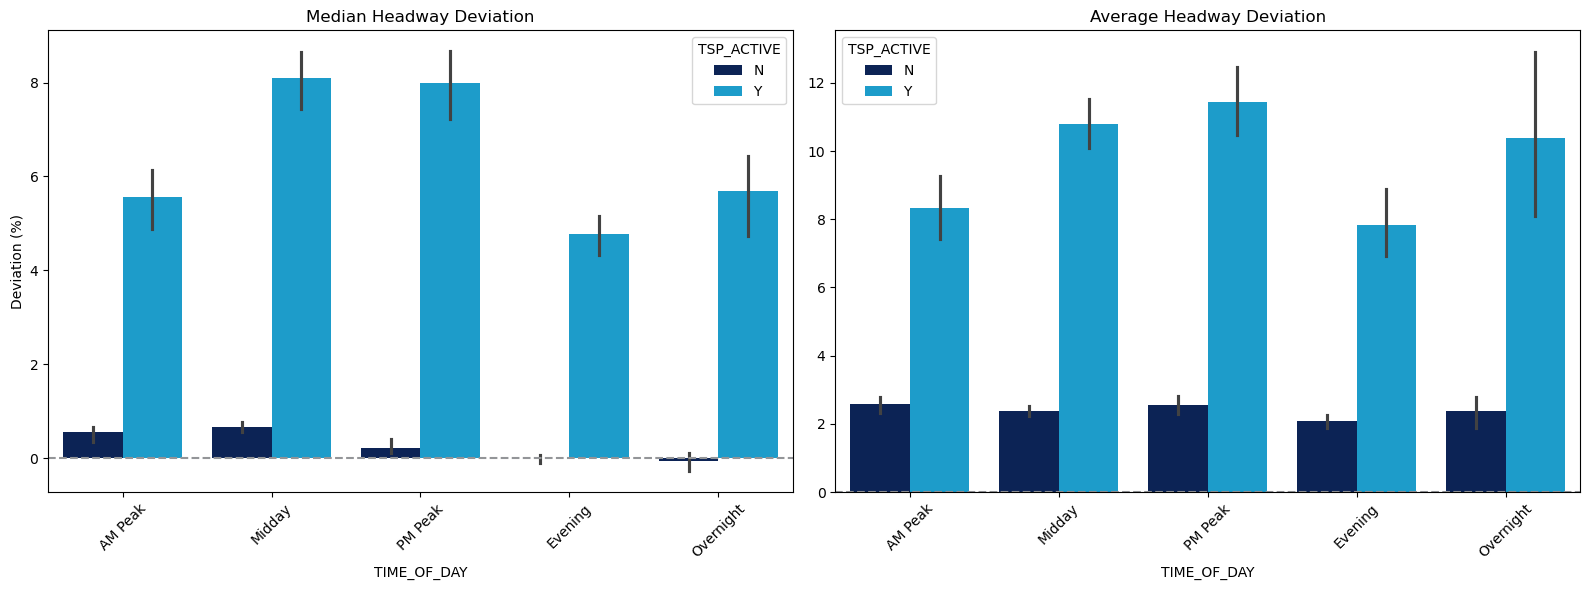

In [9]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=non_null_headway, x='TIME_OF_DAY', y='HDWY_DEV_PCT', hue='TSP_ACTIVE',
            estimator=np.median, errorbar=('ci', 95),
            palette=[we_go_palette['navy'], we_go_palette['blue']])
plt.title('Median Headway Deviation')
plt.ylabel('Deviation (%)')
plt.axhline(0, color=we_go_palette['gray'], ls='--')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=non_null_headway, x='TIME_OF_DAY', y='HDWY_DEV_PCT', hue='TSP_ACTIVE',
            estimator=np.mean, errorbar=('ci', 95),
            palette=[we_go_palette['navy'], we_go_palette['blue']])
plt.title('Average Headway Deviation')
plt.ylabel('')
plt.axhline(0, color=we_go_palette['gray'], ls='--')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [10]:
print(non_null_headway.groupby('TSP_ACTIVE')['HDWY_DEV_PCT'].agg(['mean', 'median']))

                 mean    median
TSP_ACTIVE                     
N                 inf  0.333333
Y           10.165602  6.666665


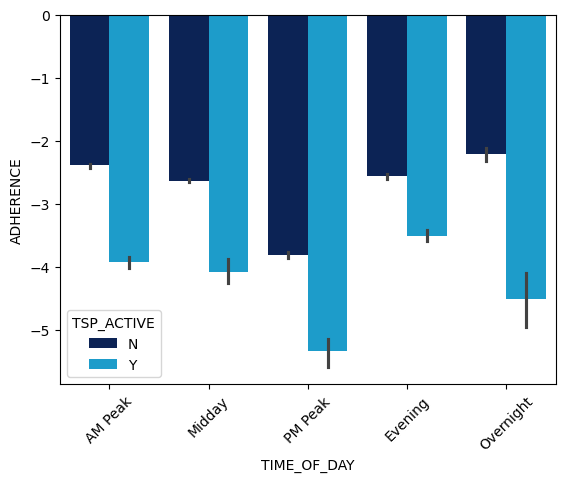

In [11]:
sns.barplot(data=non_null_headway, x='TIME_OF_DAY', y='ADHERENCE', hue='TSP_ACTIVE',
           estimator=np.mean, palette=[we_go_palette['navy'], we_go_palette['blue']])
plt.xticks(rotation=45)
plt.show()

C:\Users\seanf\anaconda3\envs\geospatial\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


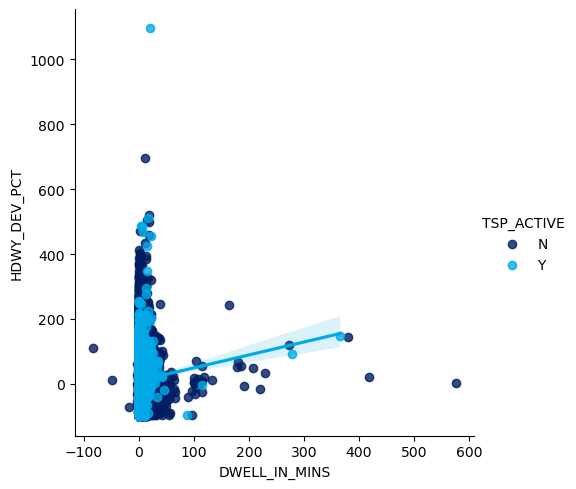

In [12]:
sns.lmplot(data=non_null_headway, x='DWELL_IN_MINS', y='HDWY_DEV_PCT', 
          hue='TSP_ACTIVE', palette=['#001E61','#00AAE7'])

In [13]:
cln_wego.groupby('TSP_ACTIVE')['TIME_OF_DAY'].value_counts()

TSP_ACTIVE  TIME_OF_DAY
N           Midday         127163
            PM Peak         73060
            AM Peak         49535
            Evening         42613
            Overnight        9295
Y           Midday           8971
            PM Peak          5787
            AM Peak          3642
            Evening          2752
            Overnight         547
Name: count, dtype: int64

In [14]:
analysis_keydates = non_null_headway[(non_null_headway['DATETIME'] >= '2025-02-01') & (non_null_headway['DATETIME'] <= '2025-05-20')]

In [15]:
analysis_keydates['TSP_ACTIVE'].value_counts()

TSP_ACTIVE
Y    21699
N     3740
Name: count, dtype: int64

In [16]:
analysis_keydates.groupby('TSP_ACTIVE')['TIME_OF_DAY'].value_counts()

TSP_ACTIVE  TIME_OF_DAY
N           Midday         1577
            PM Peak         934
            AM Peak         621
            Evening         505
            Overnight       103
Y           Midday         8971
            PM Peak        5787
            AM Peak        3642
            Evening        2752
            Overnight       547
Name: count, dtype: int64

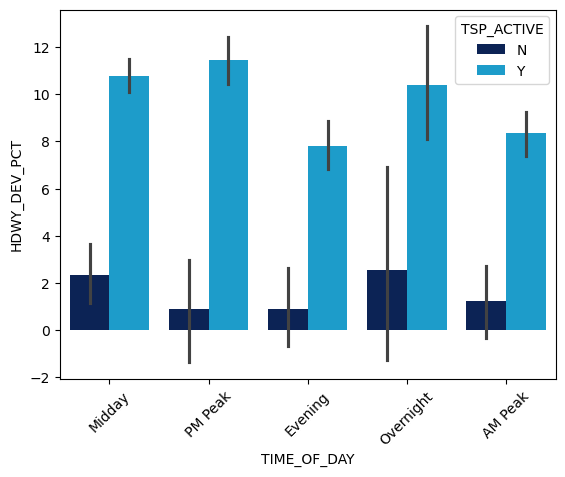

In [17]:
sns.barplot(data=analysis_keydates, x='TIME_OF_DAY', y='HDWY_DEV_PCT', hue='TSP_ACTIVE',
           estimator=np.mean, palette=[we_go_palette['navy'], we_go_palette['blue']])
plt.xticks(rotation=45)
plt.show()

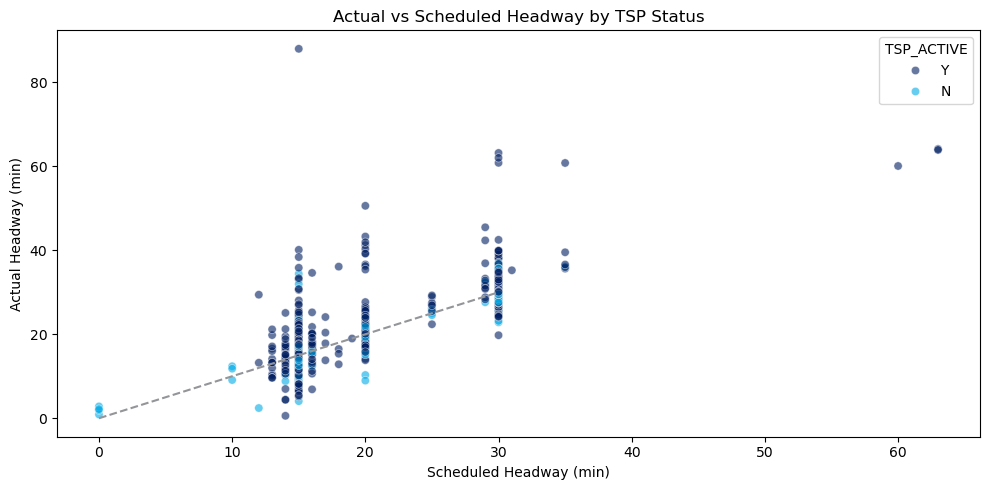

In [18]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=analysis_keydates.sample(1000),  
    x='SCHEDULED_HDWY',
    y='ACTUAL_HDWY',
    hue='TSP_ACTIVE',
    palette=[we_go_palette['navy'], we_go_palette['blue']],
    alpha=0.6
)
plt.plot([0,30], [0,30], color=we_go_palette['gray'], linestyle='--')  
plt.title('Actual vs Scheduled Headway by TSP Status')
plt.xlabel('Scheduled Headway (min)')
plt.ylabel('Actual Headway (min)')
plt.tight_layout()

In [22]:
punctuality = cln_wego.groupby('TSP_ACTIVE').agg({
    'ADJUSTED_EARLY_COUNT': 'sum',
    'ADJUSTED_LATE_COUNT': 'sum',
    'ADJUSTED_ONTIME_COUNT': 'sum'})
punctuality

,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
TSP_ACTIVE,,,
N,8634,37495,255537
Y,225,4278,17196


In [24]:
punctuality['TOTAL'] = punctuality.sum(axis=1)
for col in ['EARLY', 'LATE', 'ONTIME']:
    punctuality[f'{col}_PCT'] = punctuality[f'ADJUSTED_{col}_COUNT'] / punctuality['TOTAL'] * 100

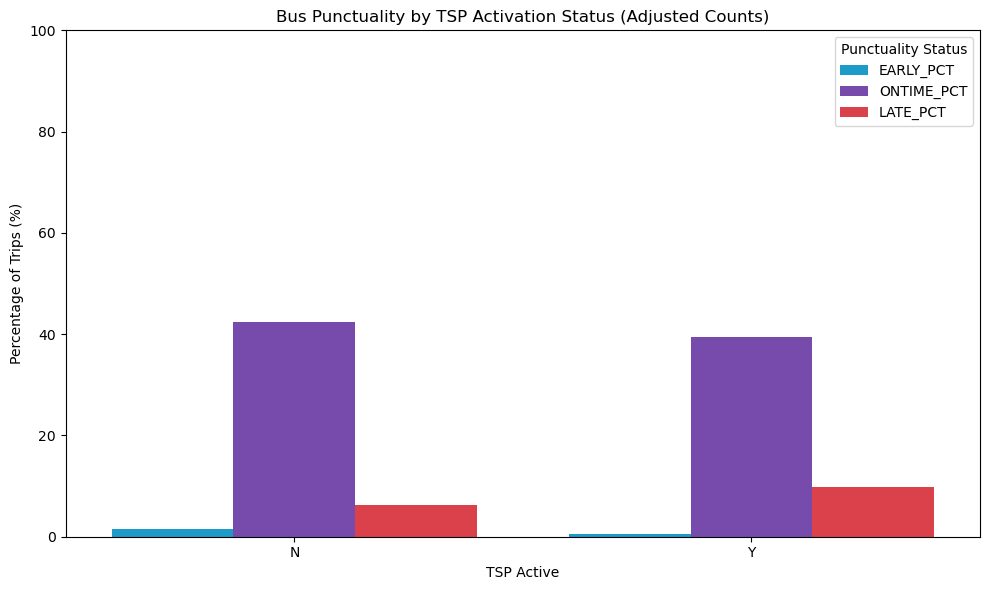

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=punctuality.reset_index().melt(id_vars='TSP_ACTIVE', 
                                      value_vars=['EARLY_PCT', 'ONTIME_PCT', 'LATE_PCT'],
                                      var_name='Status', 
                                      value_name='Percentage'),
    x='TSP_ACTIVE',
    y='Percentage',
    hue='Status',
    palette=[we_go_palette['blue'], we_go_palette['purple'], we_go_palette['red']],
    order=['N', 'Y']  
)
plt.title('Bus Punctuality by TSP Activation Status (Adjusted Counts)')
plt.ylabel('Percentage of Trips (%)')
plt.xlabel('TSP Active')
plt.ylim(0, 100)
plt.legend(title='Punctuality Status')
plt.tight_layout()